# Импорт библиотек

In [143]:
from sqlalchemy import create_engine
from dotenv import load_dotenv

import joblib
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

# import pendulum # библиотека для работы с временем
# from airflow.decorators import dag # импортируем декоратор, превращающий функцию в DAG

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import CatBoostEncoder

import matplotlib.pyplot as plt

from geopy.distance import geodesic


# Подключение к БД

In [144]:
# Загружаем переменные окружения из файла, расположенного на два уровня выше
dotenv_path = "../../.env"  # Относительный путь
load_dotenv(dotenv_path=dotenv_path)

# Source Database / Общая БД 
DB_SOURCE_HOST=os.environ.get('DB_SOURCE_HOST')
DB_SOURCE_PORT=os.environ.get('DB_SOURCE_PORT')
DB_SOURCE_NAME=os.environ.get('DB_SOURCE_NAME')
DB_SOURCE_USER=os.environ.get('DB_SOURCE_USER')
DB_SOURCE_PASSWORD=os.environ.get('DB_SOURCE_PASSWORD')

# Destination Database / Личная БД
DB_DESTINATION_HOST=os.environ.get('DB_DESTINATION_HOST')
DB_DESTINATION_PORT=os.environ.get('DB_DESTINATION_PORT')
DB_DESTINATION_NAME=os.environ.get('DB_DESTINATION_NAME')
DB_DESTINATION_USER=os.environ.get('DB_DESTINATION_USER')
DB_DESTINATION_PASSWORD=os.environ.get('DB_DESTINATION_PASSWORD')

# Общая БД
conn_common = create_engine(f'postgresql://{DB_SOURCE_USER}:{DB_SOURCE_PASSWORD}@{DB_SOURCE_HOST}:{DB_SOURCE_PORT}/{DB_SOURCE_NAME}')

# Личная БД
conn_pers = create_engine(f'postgresql://{DB_DESTINATION_USER}:{DB_DESTINATION_PASSWORD}@{DB_DESTINATION_HOST}:{DB_DESTINATION_PORT}/{DB_DESTINATION_NAME}')

# [Проект. Разработка пайплайнов подготовки данных и обучения модели]( https://practicum.yandex.ru/learn/machine-learning/courses/41232eb3-8b9d-45e9-98e6-10447557b392/sprints/425230/topics/49d56372-5c01-49a0-a570-750d1b6685ce/lessons/c0ca87a6-0443-48aa-a695-8639a25e1c8c/#69f15551-2031-4f88-8067-87070527d83e )

In [145]:
# определяем функцию получения данных из первичного источника
# она получает на вход объект соединения к первичному источнику
# и возвращает данные из всех таблиц, собранные в одном pandas.DataFrame
def extract(cnx) -> pd.DataFrame:
  # сначала напишите SQL-запрос, который объединяет все таблицы в одну
	sql_query = """
      SELECT -- flats.
            flats.id,
            flats.floor,
            flats.kitchen_area,
            flats.living_area,
            flats.total_area,
            flats.rooms,
            flats.is_apartment,
            flats.studio,
            flats.building_id,
            -- buildings.
            buildings.build_year,
            buildings.building_type_int,
            buildings.latitude,
            buildings.longitude,
            buildings.ceiling_height,
            buildings.flats_count,
            buildings.floors_total,
            buildings.has_elevator,
            -- flats.
            flats.price,
      FROM flats
      LEFT JOIN buildings ON flats.building_id = buildings.id
      """
	data = pd.read_sql(sql_query, cnx) #исполним написанный запрос
	return data

In [146]:
sql_query = """
      SELECT -- flats.
            flats.id,
            flats.floor,
            flats.kitchen_area,
            flats.living_area,
            flats.total_area,
            flats.rooms,
            flats.is_apartment,
            flats.studio,
            flats.building_id,
            -- buildings.
            buildings.build_year,
            buildings.building_type_int,
            buildings.latitude,
            buildings.longitude,
            buildings.ceiling_height,
            buildings.flats_count,
            buildings.floors_total,
            buildings.has_elevator,
            -- flats.
            flats.price
      FROM public.flats AS flats
      LEFT JOIN public.buildings AS buildings ON flats.building_id = buildings.id
      """
data = pd.read_sql(sql_query, conn_pers)

In [147]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141362 entries, 0 to 141361
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 141362 non-null  int64  
 1   floor              141362 non-null  int64  
 2   kitchen_area       141362 non-null  float64
 3   living_area        141362 non-null  float64
 4   total_area         141362 non-null  float64
 5   rooms              141362 non-null  int64  
 6   is_apartment       141362 non-null  bool   
 7   studio             141362 non-null  bool   
 8   building_id        141362 non-null  int64  
 9   build_year         141362 non-null  int64  
 10  building_type_int  141362 non-null  int64  
 11  latitude           141362 non-null  float64
 12  longitude          141362 non-null  float64
 13  ceiling_height     141362 non-null  float64
 14  flats_count        141362 non-null  int64  
 15  floors_total       141362 non-null  int64  
 16  ha

In [148]:
sql_query = """
      SELECT *
      FROM real_estate_prices
      """
real_estate_prices = pd.read_sql(sql_query, conn_pers)

In [149]:
real_estate_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141362 entries, 0 to 141361
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 141362 non-null  int64  
 1   floor              141362 non-null  int64  
 2   kitchen_area       141362 non-null  float64
 3   living_area        141362 non-null  float64
 4   total_area         141362 non-null  float64
 5   rooms              141362 non-null  int64  
 6   is_apartment       141362 non-null  bool   
 7   studio             141362 non-null  bool   
 8   building_id        141362 non-null  int64  
 9   build_year         141362 non-null  int64  
 10  building_type_int  141362 non-null  int64  
 11  latitude           141362 non-null  float64
 12  longitude          141362 non-null  float64
 13  ceiling_height     141362 non-null  float64
 14  flats_count        141362 non-null  int64  
 15  floors_total       141362 non-null  int64  
 16  ha

### Предобработка данных

In [150]:
data = real_estate_prices

#### Дубликаты

In [151]:
feature_cols = data.columns.drop(['id'])
is_duplicated_features = data.duplicated(subset=feature_cols, keep='last')
print(len(data[is_duplicated_features]))

9116


In [152]:
def remove_duplicates(data: pd.DataFrame):
    """
    Функция удаления дубликатов
    """
    feature_cols = data.columns.drop(['id'])
    is_duplicated_features = data.duplicated(subset=feature_cols, keep='last')
    data = data[~is_duplicated_features].reset_index(drop=True)
    return data

In [153]:
data = remove_duplicates(data)

#### Выбросы

In [154]:
data.describe()

,id,floor,kitchen_area,living_area,total_area,rooms,building_id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,price
count,132246.000000,132246.000000,132246.000000,132246.000000,132246.000000,132246.000000,132246.000000,132246.000000,132246.000000,132246.000000,132246.000000,132246.000000,132246.000000,132246.000000,1.322460e+05
mean,71787.895997,7.455651,8.964356,30.990703,62.038371,2.124200,14017.299760,1986.492476,3.241240,55.730344,37.589355,2.752011,251.587723,14.077605,1.933210e+07
std,40894.234082,5.703849,5.212305,23.667590,39.784039,0.990495,6974.598002,22.067968,1.459392,0.102887,0.150453,0.222892,206.994097,6.881819,6.757713e+07
min,0.000000,1.000000,0.000000,0.000000,11.000000,1.000000,1.000000,1901.000000,0.000000,55.211460,36.864372,2.000000,1.000000,1.000000,1.100000e+01
25%,36576.250000,3.000000,6.100000,19.000000,39.200001,1.000000,8509.000000,1969.000000,2.000000,55.653915,37.491764,2.640000,111.000000,9.000000,8.900000e+06
50%,72493.500000,6.000000,8.700000,29.400000,52.900002,2.000000,14300.000000,1985.000000,4.000000,55.724754,37.581272,2.640000,199.000000,14.000000,1.180000e+07
75%,107314.750000,10.000000,10.200000,41.000000,71.699997,3.000000,20409.000000,2007.000000,4.000000,55.808098,37.692499,2.800000,323.000000,17.000000,1.685000e+07
max,141361.000000,56.000000,203.000000,700.000000,960.299988,20.000000,24620.000000,2023.000000,6.000000,56.011032,37.946411,27.000000,4455.000000,99.000000,9.873738e+09


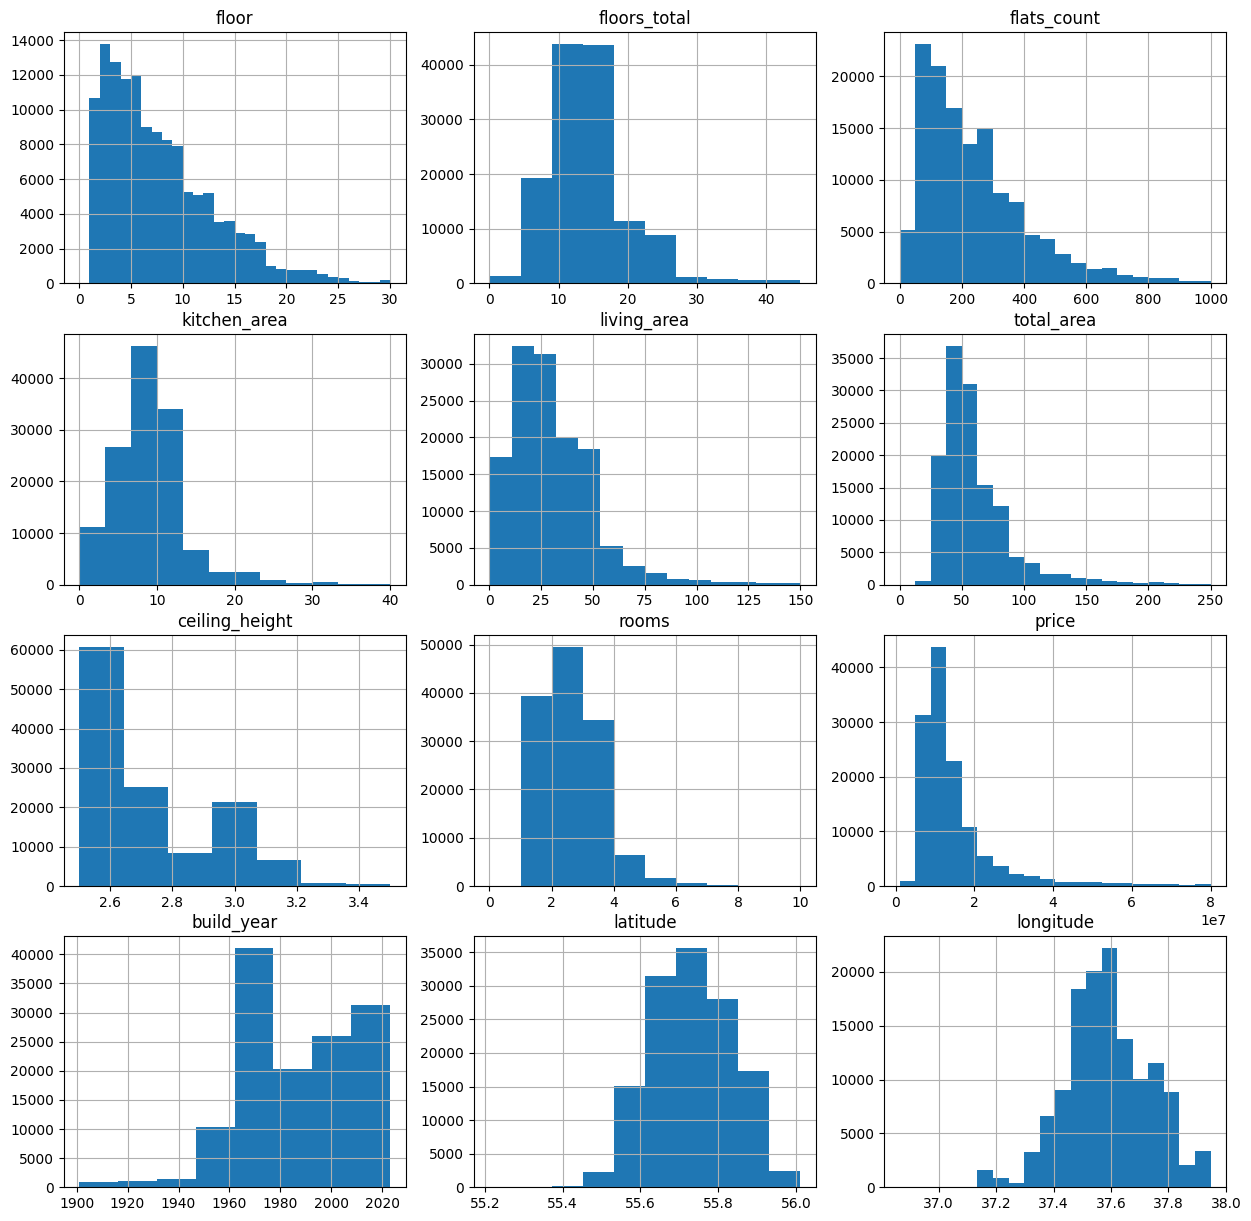

In [155]:
# Создаем фигуру и оси
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

data['floor'].hist(bins=30, range=(0, 30), ax=axs[0, 0]).set_title('floor')
data['floors_total'].hist(bins=10, range=(0, 45), ax=axs[0, 1]).set_title('floors_total')
data['flats_count'].hist(bins=20, range=(0, 1000), ax=axs[0, 2]).set_title('flats_count')

data['kitchen_area'].hist(bins=12, range=(0, 40), ax=axs[1, 0]).set_title('kitchen_area')
data['living_area'].hist(bins=14, range=(0, 150), ax=axs[1, 1]).set_title('living_area')
data['total_area'].hist(bins=20, range=(0, 250), ax=axs[1, 2]).set_title('total_area')

data['ceiling_height'].hist(bins=7, range=(2.5, 3.5), ax=axs[2, 0]).set_title('ceiling_height')
data['rooms'].hist(bins=10, range=(0, 10), ax=axs[2, 1]).set_title('rooms')
data['price'].hist(bins=20, range=(1e6, 80e6), ax=axs[2, 2]).set_title('price')

data['build_year'].hist(bins=8, range=(1901, 2023), ax=axs[3, 0]).set_title('build_year')
data['latitude'].hist(bins=10, ax=axs[3, 1]).set_title('latitude')
data['longitude'].hist(bins=20, ax=axs[3, 2]).set_title('longitude');

In [156]:
def remove_outliers(data: pd.DataFrame):
    """
    Функция удаления редких и аномальных значений (выбросов)
    """
    data_clean = data[data['floor'].between(1, 30) &
                  data['floors_total'].between(1, 45) &
                  data['flats_count'].between(1, 1000) &
                  data['kitchen_area'].between(0, 40) &
                  data['living_area'].between(0, 150) &
                  data['total_area'].between(20, 250) &
                  data['ceiling_height'].between(2.5, 3.5) &
                  data['rooms'].between(1, 8) &
                  data['price'].between(1e6, 80e6) &
                  data['build_year'].between(1900, pd.Timestamp.now().year)]
    return data_clean

In [157]:
data_clean = remove_outliers(data)

In [158]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118208 entries, 0 to 132245
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 118208 non-null  int64  
 1   floor              118208 non-null  int64  
 2   kitchen_area       118208 non-null  float64
 3   living_area        118208 non-null  float64
 4   total_area         118208 non-null  float64
 5   rooms              118208 non-null  int64  
 6   is_apartment       118208 non-null  bool   
 7   studio             118208 non-null  bool   
 8   building_id        118208 non-null  int64  
 9   build_year         118208 non-null  int64  
 10  building_type_int  118208 non-null  int64  
 11  latitude           118208 non-null  float64
 12  longitude          118208 non-null  float64
 13  ceiling_height     118208 non-null  float64
 14  flats_count        118208 non-null  int64  
 15  floors_total       118208 non-null  int64  
 16  has_ele

#### Генерация новых признаков

In [159]:
# Проведём категоризацию столбца 'floor'. Распределим значения группам: первый, последний, другой.
def category_floor(row):
    """
    Определяет категорию этажа: первый, последний, не крайний.
    """

    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'не крайний'

In [160]:
def calculate_distance_from_moscow_center(row):
    """
    Вычисляет расстояние от центра Москвы до заданной точки.

    Args:
        latitude (float): Широта объекта.
        longitude (float): Долгота объекта.

    Returns:
        float: Расстояние в километрах.
    """

    # Координаты центра Москвы (приблизительные)
    moscow_center = (55.7558, 37.6173) # Широта, Долгота

    # Координаты объекта
    object_coords = (row['latitude'], row['longitude'])

    # Вычисление расстояния с использованием geodesic (более точный метод)
    distance = geodesic(moscow_center, object_coords).km

    return distance

In [161]:
def add_features(data: pd.DataFrame):
    """
    Генерирует новые признаки
    """
    # Создадим новый столбец с категорией этажа.
    data.insert(loc=1, 
                column='category_floor', 
                value = data.apply(category_floor, axis=1))
    
    # Создадим новый столбец с расстоянием от центра Москвы.
    data.insert(loc=12, 
                column='distance', 
                value = data.apply(calculate_distance_from_moscow_center, axis=1))

    return data

In [162]:
data_clean = add_features(data_clean)

#### Округление данных

In [163]:
# Произведём округление общей площади с точностью 10 и 100 кв. м.
def area_round(area):
    """
    Округляет площадь для удобства восприятия и моделирования
    """
    if 0 <= area < 100:
        return round(area)
    elif area >= 100:
        return round(area, -1)
    else:
        return np.nan


In [164]:
def areas_round(data: pd.DataFrame):
    """
    Округляет площади для удобства восприятия и моделирования
    """
    for i in ('kitchen', 'living', 'total'):
        data.loc[:, f'{i}_area'] = data[f'{i}_area'].apply(area_round)
    
    return data

In [165]:
data_clean = areas_round(data_clean)

In [167]:
data_clean.head()

,id,category_floor,floor,kitchen_area,living_area,total_area,rooms,is_apartment,studio,building_id,build_year,building_type_int,distance,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,price
0,0,не крайний,9,10.0,20.0,35.0,1,False,False,6220,1965,6,11.155702,55.717113,37.781120,2.64,84,12,True,9500000
1,1,не крайний,7,0.0,17.0,43.0,1,False,False,18012,2001,2,4.386558,55.794849,37.608013,3.00,97,10,True,13500000
2,2,не крайний,9,9.0,32.0,56.0,2,False,False,17821,2000,4,9.238845,55.740040,37.761742,2.70,80,10,True,13500000
3,3,первый,1,10.0,43.0,76.0,3,False,False,18579,2002,4,9.773902,55.672016,37.570877,2.64,771,17,True,20000000
4,4,не крайний,3,3.0,14.0,24.0,1,False,False,9293,1971,1,8.168337,55.808807,37.707306,2.60,208,9,True,5200000


In [166]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118208 entries, 0 to 132245
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 118208 non-null  int64  
 1   category_floor     118208 non-null  object 
 2   floor              118208 non-null  int64  
 3   kitchen_area       118208 non-null  float64
 4   living_area        118208 non-null  float64
 5   total_area         118208 non-null  float64
 6   rooms              118208 non-null  int64  
 7   is_apartment       118208 non-null  bool   
 8   studio             118208 non-null  bool   
 9   building_id        118208 non-null  int64  
 10  build_year         118208 non-null  int64  
 11  building_type_int  118208 non-null  int64  
 12  distance           118208 non-null  float64
 13  latitude           118208 non-null  float64
 14  longitude          118208 non-null  float64
 15  ceiling_height     118208 non-null  float64
 16  flats_c